#Load Data


In [1]:
BASE_DIR = r'C:\Users\Gaertner\Documents\mestrado\grid_rj'

#Path datas

In [2]:
import os

image_paths, mask_paths = [], []
for i in range(1, 2801):
    img_name = f'sentinel1_grid_cell_{i}.tif'
    mask_name = f'mask_grid_cell_{i}.tif'
    img_path = os.path.join(BASE_DIR, img_name)
    mask_path = os.path.join(BASE_DIR, mask_name)
    if os.path.exists(img_path) and os.path.exists(mask_path):
        image_paths.append(img_path)
        mask_paths.append(mask_path)

print(f"Total de pares de imagem/máscara encontrados: {len(image_paths)}")

Total de pares de imagem/máscara encontrados: 1058


#Modelo

In [3]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name="efficientnet-b4",
        encoder_weights="imagenet",
        in_channels=2,
        classes=1,
        activation=None
    )
    return model

c:\Users\Gaertner\Documents\mestrado\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ic| im_train.shape: (102, 110)
ic| mask_train.shape: (102, 110)


Tamanho do conjunto de Treino: 740
Tamanho do conjunto de Validação: 159
Tamanho do conjunto de Teste: 159


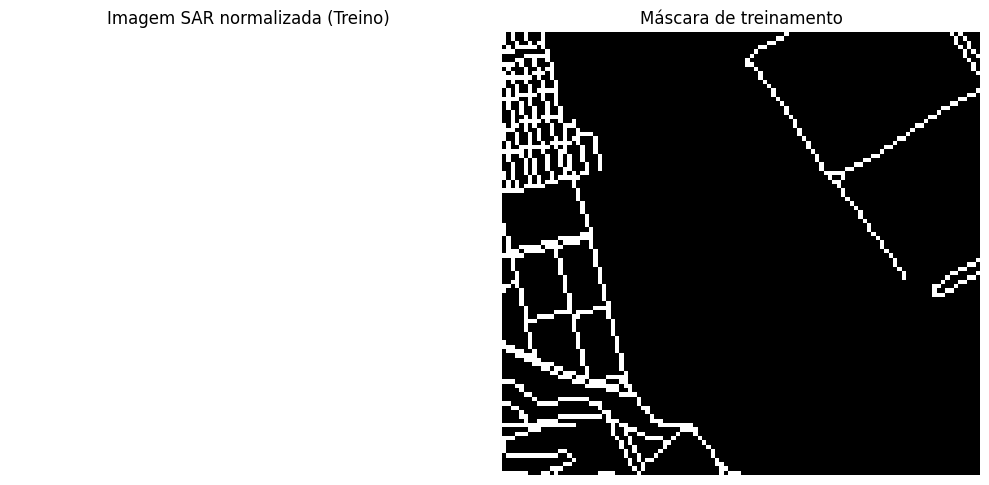

ic| im_test.shape: (102, 110)
ic| mask_test.shape: (102, 110)


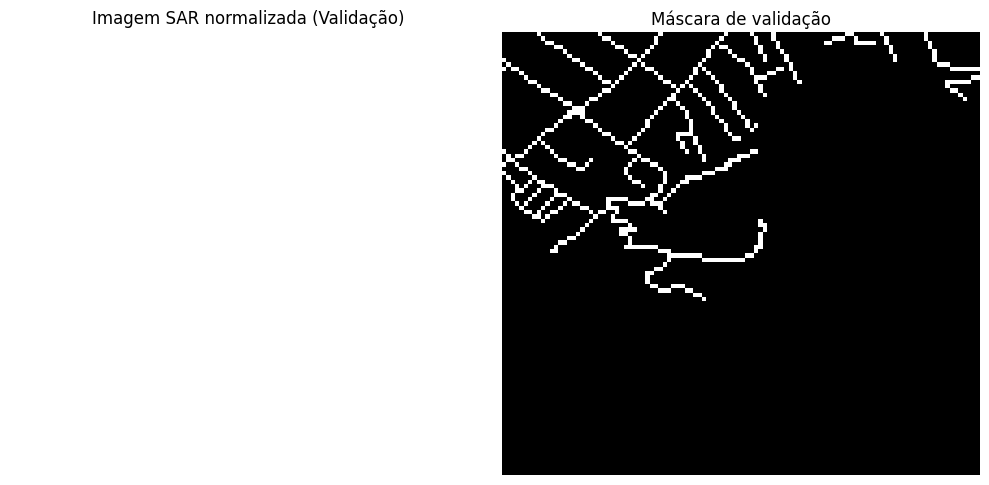

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from icecream import ic
from scipy.ndimage import uniform_filter
from sklearn.model_selection import train_test_split
import rasterio


def lee_filter(img, size=5):
    """Aplica o Filtro de Lee para redução de ruído speckle em imagens SAR."""
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = np.var(img)

    # Adiciona um epsilon para evitar divisão por zero
    epsilon = 1e-8
    img_weights = img_variance / (img_variance + overall_variance + epsilon)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output.astype(np.float32)

def read_tiff(tiff_file, apply_lee=False):
    """Lê arquivo .tif e aplica filtro de Lee se for imagem SAR monocanal."""
    #data = gdal.Open(tiff_file).ReadAsArray()
    with rasterio.open(tiff_file) as src:
        data = src.read()
    if data.ndim == 3:
        # If it's a 3D array and not RGB/RGBA, assume it's multi-band SAR and take the first band
        if data.shape[-1] not in [3, 4]:
            data = data[0, :, :] # Select the first band
        else:
             return np.transpose(data, (1, 2, 0)) # Transpose for matplotlib if it's RGB/RGBA
    # If it's 2D or now 2D after selecting a band, apply Lee filter if requested
    if apply_lee:
        data = lee_filter(data.astype(np.float32))
    return data


# ==============================================================================
# 3. DIVISÃO DOS DADOS (TREINO, VALIDAÇÃO E TESTE)
# ==============================================================================

# Primeiro, separamos 15% para o conjunto de teste
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.15, random_state=42
)

# Do restante (85%), separamos uma parte para validação (aprox. 15% do total)
# 0.15 / 0.85 ~= 0.1765
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.1765, random_state=42
)

print(f"Tamanho do conjunto de Treino: {len(train_images)}")
print(f"Tamanho do conjunto de Validação: {len(val_images)}")
print(f"Tamanho do conjunto de Teste: {len(test_images)}")

# Load and display the first image and mask from the training set
if train_images and train_masks:
    im_train = read_tiff(train_images[0], apply_lee=True)
    mask_train = read_tiff(train_masks[0])

    ic(im_train.shape)
    ic(mask_train.shape)

    # Normalizar e exibir
    im_train_norm = (im_train - im_train.min()) / (im_train.max() - im_train.min())

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(im_train_norm, cmap="gray")
    axes[0].set_title("Imagem SAR normalizada (Treino)")
    axes[0].axis("off")
    axes[1].imshow(mask_train, cmap="gray")
    axes[1].set_title("Máscara de treinamento")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No training images or masks found.")

# Load and display the first image and mask from the validation set
if val_images and val_masks:
    im_test = read_tiff(val_images[0], apply_lee=True)
    mask_test = read_tiff(val_masks[0])

    ic(im_test.shape)
    ic(mask_test.shape)

    im_test_norm = (im_test - im_test.min()) / (im_test.max() - im_test.min())

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(im_test_norm, cmap="gray")
    axes[0].set_title("Imagem SAR normalizada (Validação)")
    axes[0].axis("off")
    axes[1].imshow(mask_test, cmap="gray")
    axes[1].set_title("Máscara de validação")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No validation images or masks found.")

#Train

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms # Manter para a validação
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import rasterio
import numpy as np
from sklearn.metrics import f1_score, jaccard_score

# Detecta se CUDA está disponível
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 256

def pad_to_multiple(img, multiple=16):
    h, w = img.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    return np.pad(img, ((0, pad_h), (0, pad_w)), mode='reflect')

# Dataset personalizado
class SARViasDataset(Dataset):
    """
    Dataset para carregar imagens SAR com 2 bandas (VV, VH).
    Aplica o Filtro de Lee para redução de speckle e depois normaliza para [0, 1].
    """
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Leitura da imagem SAR com as duas bandas
        with rasterio.open(self.image_paths[idx]) as img_src:
            image = img_src.read().astype(np.float32)

        # Leitura da máscara
        with rasterio.open(self.mask_paths[idx]) as msk_src:
            mask = (msk_src.read(1) > 0).astype(np.float32)

        # --- ORDEM CORRETA DO PRÉ-PROCESSAMENTO ---
        # 1. Aplica o Filtro de Lee em cada banda
        image[0] = lee_filter(image[0]) # Banda VV
        image[1] = lee_filter(image[1]) # Banda VH

        # 2. Normaliza cada banda (já filtrada) para o intervalo [0, 1]
        for i in range(image.shape[0]):
            band = image[i]
            min_val, max_val = np.min(band), np.max(band)
            if max_val > min_val:
                image[i] = (band - min_val) / (max_val - min_val)
            else:
                image[i] = np.zeros_like(band)

        # 3. Aplica as transformações (data augmentation)
        if self.transform:
            augmented = self.transform(image=np.transpose(image, (1, 2, 0)), mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)

# --- Pipelines de Augmentation ---
train_transform = A.Compose([
    ############################ ISSO É UM ERRO GRAVE! ########################################
    #A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    #A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    ToTensorV2(),
])


BATCH_SIZE = 4
# --- Criar Datasets e DataLoaders ---
train_dataset = SARViasDataset(train_images, train_masks, transform=train_transform)
val_dataset = SARViasDataset(val_images, val_masks, transform=val_test_transform)
test_dataset = SARViasDataset(test_images, test_masks, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Batch size 1 para avaliação e visualização


In [ ]:
for pair in train_loader:
    print(pair)
    break

In [ ]:
# Célula de Treinamento Completa com Early Stopping

# --- ADIÇÃO 1: Classe para o Early Stopping ---
# Esta classe monitora a perda de validação e para o treino se ela não melhorar.
class EarlyStopper:
    def __init__(self, patience=20, min_delta=0, path='best_model.pth'):
        """
        Args:
            patience (int): Quantas épocas esperar após a última vez que a perda de validação melhorou.
            min_delta (float): Mudança mínima na perda monitorada para contar como uma melhoria.
            path (str): Caminho para salvar o melhor modelo.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            # A perda melhorou, salva o modelo e reseta o contador
            self.best_loss = val_loss
            self.counter = 0
            print(f"--> Perda de validação melhorou para {self.best_loss:.4f}. Salvando modelo...")
            torch.save(model.state_dict(), self.path)
        else:
            # A perda não melhorou
            self.counter += 1
            print(f"--> EarlyStopping counter: {self.counter} de {self.patience}")
            if self.counter >= self.patience:
                print("--> Early stopping ativado!")
                self.early_stop = True

# --- Loop de Treinamento com Early Stopping Integrado ---

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100
WEIGHT_DECAY = 1e-5

model = build_model().to(DEVICE)

# Função de perda combinada para melhor estabilidade
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss()

    def forward(self, y_pred, y_true):
        return self.dice_loss(y_pred, y_true) + self.bce_loss(y_pred, y_true)

loss_fn = CombinedLoss()

# Otimizador e Agendador
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# --- ADIÇÃO 2: Instanciar o Early Stopper ---
early_stopper = EarlyStopper(patience=20, path='unet_sar_best.pth')

print("Iniciando treinamento com data augmentation e early stopping...")

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validação
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS}:")
    print(f"  - Perda de Treino: {avg_train_loss:.4f}")
    print(f"  - Perda de Validação: {avg_val_loss:.4f}")
    print(f"  - Taxa de Aprendizado: {optimizer.param_groups[0]['lr']:.6f}")

    early_stopper(avg_val_loss, model)
    if early_stopper.early_stop:
        break

print("\nTreinamento concluído!")

# Carregar o melhor modelo salvo pelo Early Stopper para uso futuro
print(f"Carregando o melhor modelo salvo em '{early_stopper.path}'")
model.load_state_dict(torch.load(early_stopper.path))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Iniciando treinamento com data augmentation e early stopping...

Época 1/100:
  - Perda de Treino: 1.4579
  - Perda de Validação: 1.3821
  - Taxa de Aprendizado: 0.000100
--> Perda de validação melhorou para 1.3821. Salvando modelo...

Época 2/100:
  - Perda de Treino: 1.2552
  - Perda de Validação: 1.3642
  - Taxa de Aprendizado: 0.000100
--> Perda de validação melhorou para 1.3642. Salvando modelo...

Época 3/100:
  - Perda de Treino: 1.2057
  - Perda de Validação: 1.2354
  - Taxa de Aprendizado: 0.000100
--> Perda de validação melhorou para 1.2354. Salvando modelo...

Época 4/100:
  - Perda de Treino: 1.1899
  - Perda de Validação: 1.2485
  - Taxa de Aprendizado: 0.000100
--> EarlyStopping counter: 1 de 20

Época 5/100:
  - Perda de Treino: 1.1872
  - Perda de Validação: 1.2379
  - Taxa de Aprendizado: 0.000100
--> EarlyStopping counter: 2 de 20

Época 6/100:
  - Perda de Treino: 1.1872
  - Perda de Validação: 1.2078
  - Taxa de Aprendizado: 0.000100
--> Perda de validação melhorou 

<All keys matched successfully>


Iniciando avaliação final no conjunto de teste...

--- Resultados Finais no Conjunto de Teste ---
Perda de Teste: 1.2013
IoU (Intersection over Union): 0.0000
F1-Score: 0.0000


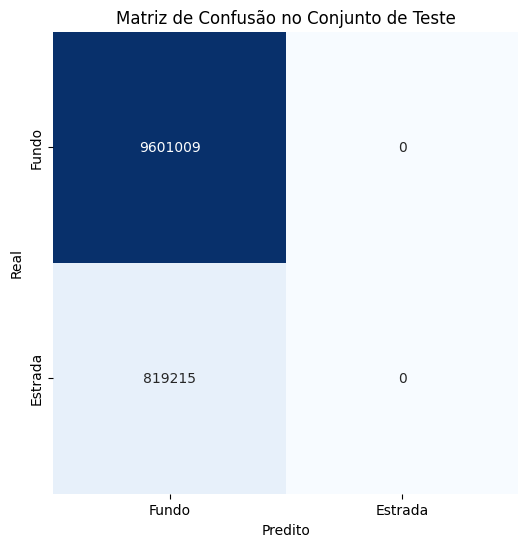

In [ ]:
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
import seaborn as sns

# ==============================================================================
# 8. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
# ==============================================================================
print("\nIniciando avaliação final no conjunto de teste...")

# Carregar o melhor modelo salvo pelo Early Stopper
model.load_state_dict(torch.load(early_stopper.path))

def evaluate_model(loader, model, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds, all_masks = [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            predictions = model(images)
            loss = loss_fn(predictions, masks)
            total_loss += loss.item()

            # Converte predições para binário (0 ou 1)
            preds_binary = (torch.sigmoid(predictions) > 0.5).cpu().numpy().flatten()
            masks_cpu = masks.cpu().numpy().flatten()

            all_preds.extend(preds_binary)
            all_masks.extend(masks_cpu)

    avg_loss = total_loss / len(loader)
    iou = jaccard_score(all_masks, all_preds, zero_division=0)
    f1 = f1_score(all_masks, all_preds, zero_division=0)

    return avg_loss, iou, f1, np.array(all_masks), np.array(all_preds)

test_loss, test_iou, test_f1, all_true_masks, all_predictions = evaluate_model(
    test_loader, model, loss_fn, DEVICE
)

print("\n--- Resultados Finais no Conjunto de Teste ---")
print(f"Perda de Teste: {test_loss:.4f}")
print(f"IoU (Intersection over Union): {test_iou:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Gerar e exibir a Matriz de Confusão
cm = confusion_matrix(all_true_masks, all_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fundo', 'Estrada'], yticklabels=['Fundo', 'Estrada'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão no Conjunto de Teste')
plt.show()


#Inferência

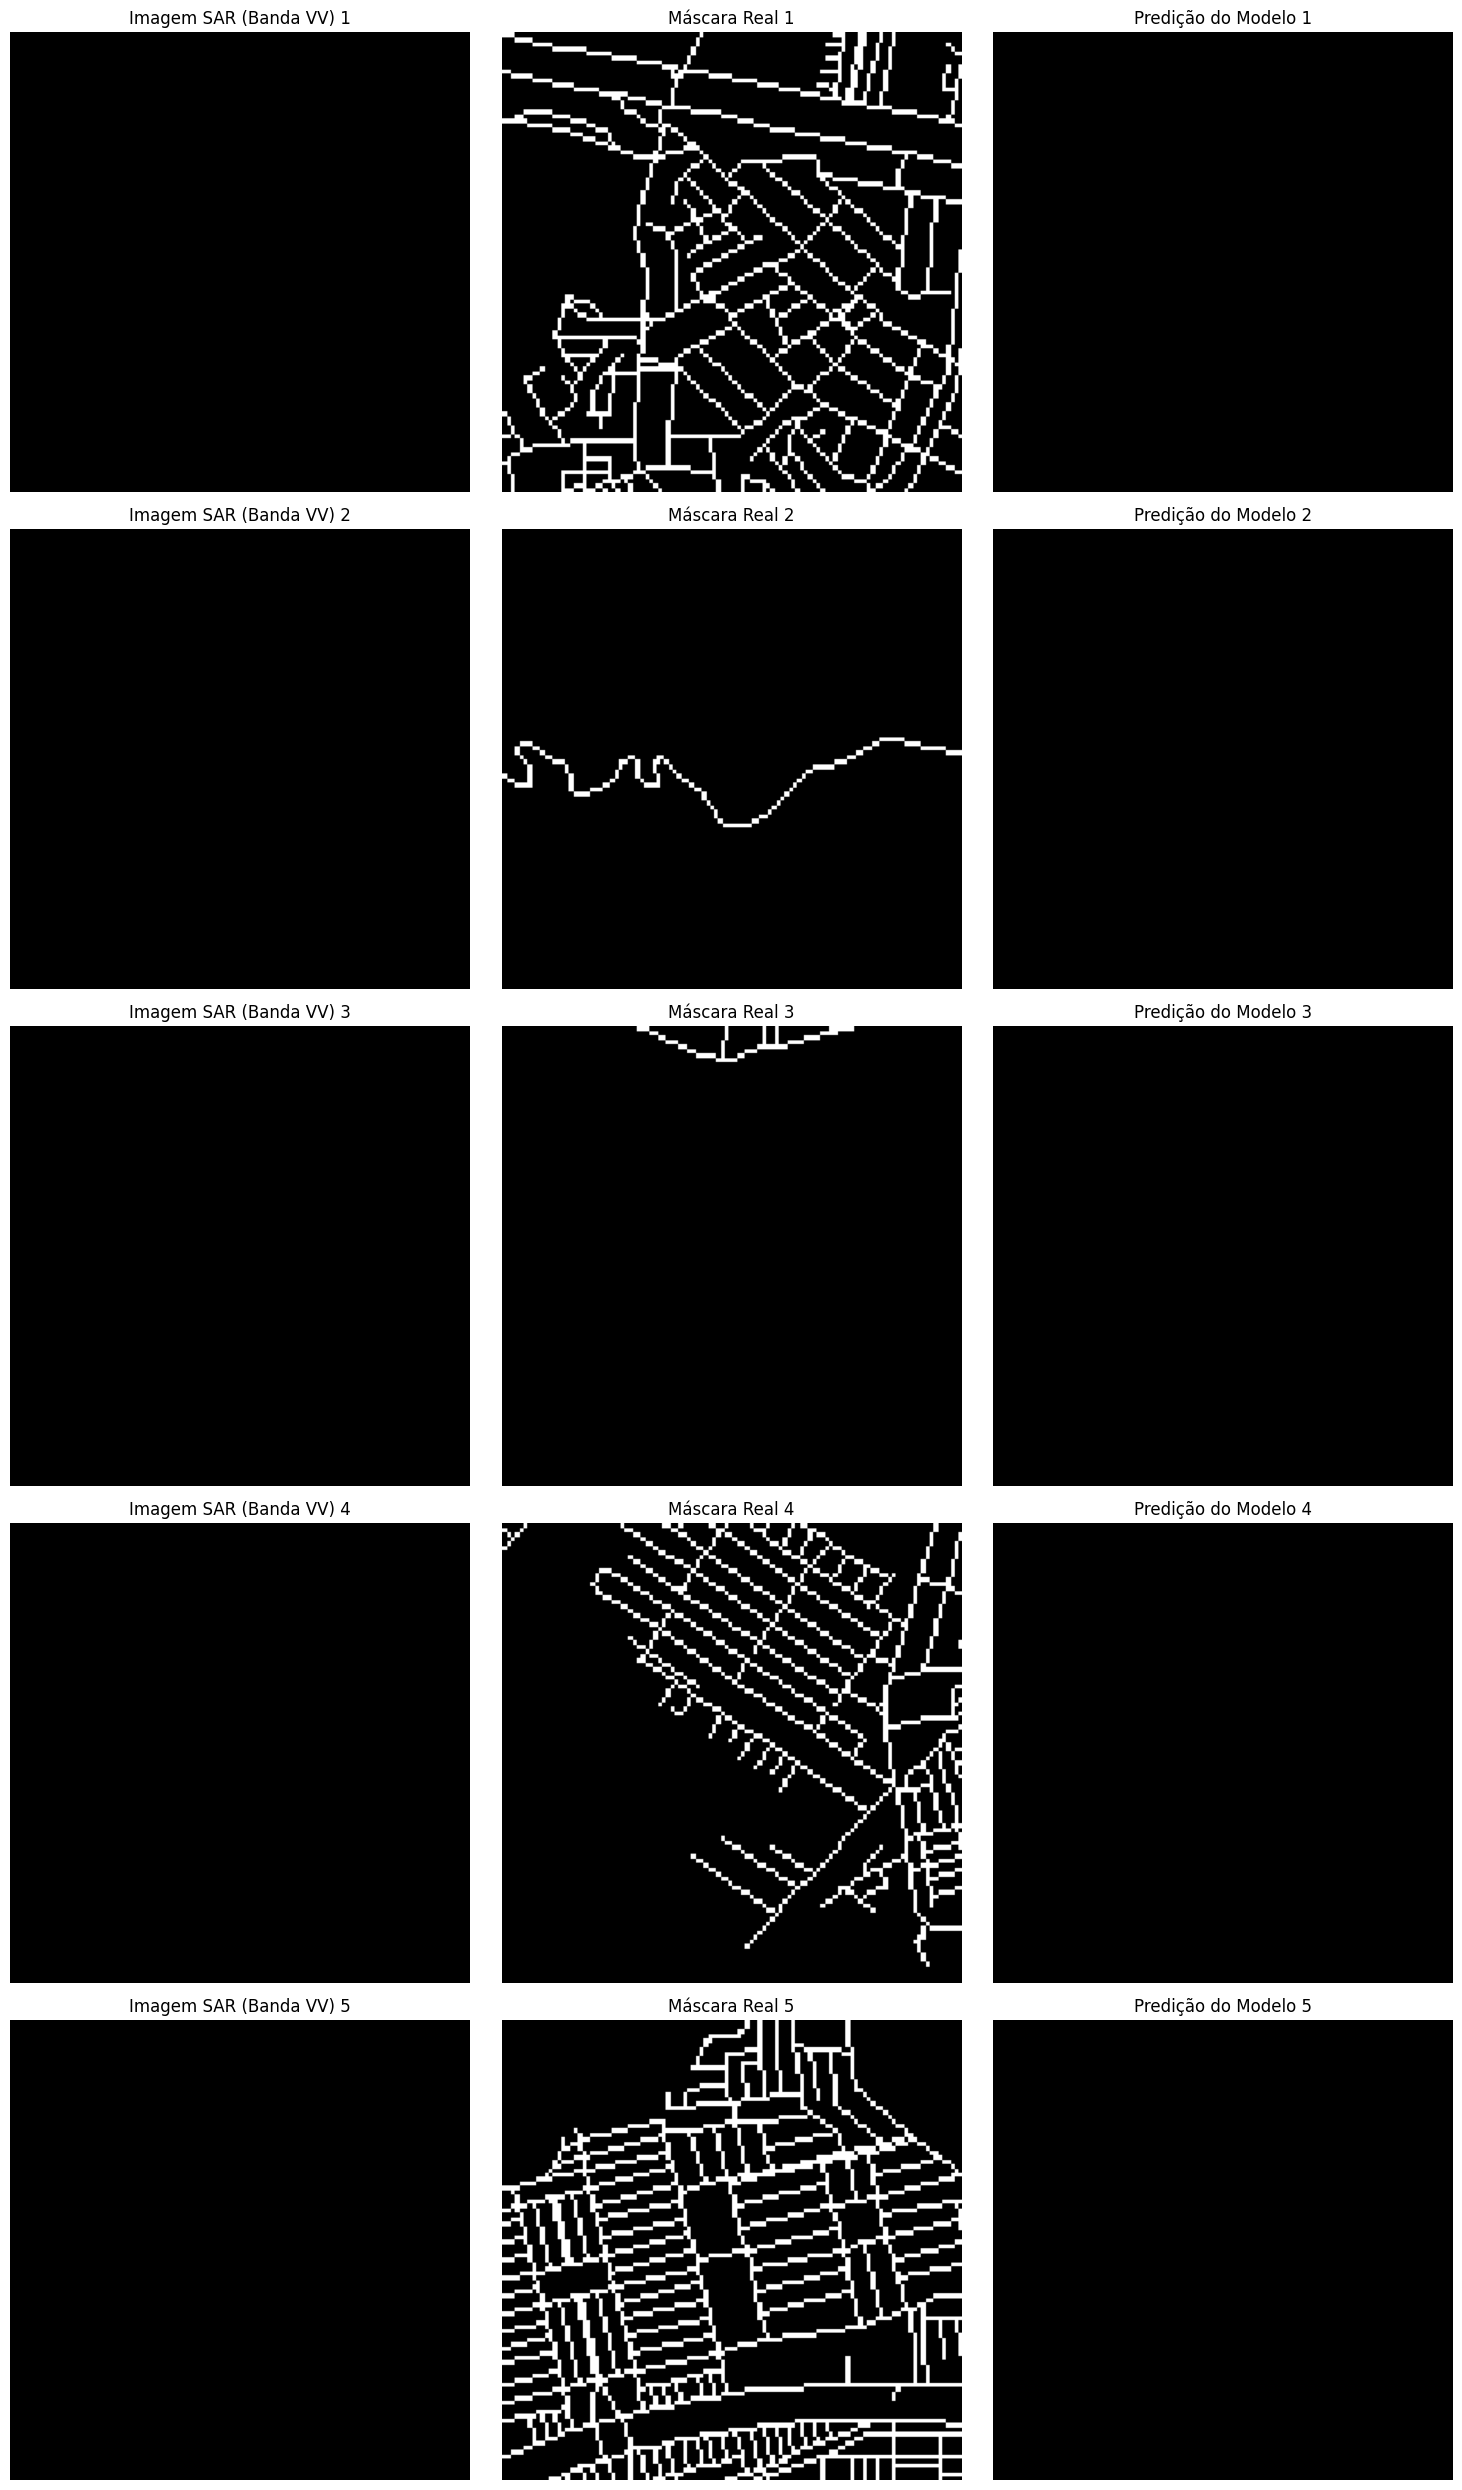

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# ==============================================================================
# 9. VISUALIZAÇÃO DOS RESULTADOS (INFERÊNCIA)
# ==============================================================================

def visualize_results(loader, model, device, num_examples=5):
    model.eval()
    num_to_show = min(num_examples, len(loader.dataset))

    plt.figure(figsize=(15, num_to_show * 5))

    with torch.no_grad():
        for i, (image_tensor, mask_tensor) in enumerate(loader):
            if i >= num_to_show:
                break

            # Para visualização, usamos apenas a primeira banda (VV)
            image_vis = image_tensor[0][0].cpu().numpy() # Shape [C, H, W] -> [H, W]
            mask_true = mask_tensor[0].cpu().numpy().squeeze()

            image_tensor = image_tensor.to(device)
            prediction = model(image_tensor)
            mask_pred = (torch.sigmoid(prediction[0]).cpu().numpy().squeeze() > 0.5)

            plt.subplot(num_to_show, 3, i*3 + 1)
            plt.imshow(image_vis, cmap='gray')
            plt.title(f'Imagem SAR (Banda VV) {i+1}')
            plt.axis('off')

            plt.subplot(num_to_show, 3, i*3 + 2)
            plt.imshow(mask_true, cmap='gray')
            plt.title(f'Máscara Real {i+1}')
            plt.axis('off')

            plt.subplot(num_to_show, 3, i*3 + 3)
            plt.imshow(mask_pred, cmap='gray')
            plt.title(f'Predição do Modelo {i+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar resultados no conjunto de teste
visualize_results(test_loader, model, DEVICE, num_examples=5)